In [3]:
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.colors as colors
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable
import numpy as np
from prettytable import PrettyTable

def plot_histograms(super_histograms,scaling=1000,upper_cutoff=None):

    max_num = 0
    min_num = 1000000000000000000000000000000
    steps = []
    for histograms in super_histograms:
        local_steps = []
        for hist in histograms:
            local_steps.append(hist.step)
        if len(local_steps) > len(steps):
            steps = local_steps
    
    for histograms in super_histograms:
        for hist in histograms:
            num = hist.histogram_value.num
            if num > max_num:
                max_num = num
            if num < min_num:
                min_num = num

    fig,axs = plt.subplots(len(steps),len(super_histograms))

    if len(super_histograms) == 1:
        axs = axs[:,None]

    #cmap = plt.cm.viridis 
    #cmap = colors.LinearSegmentedColormap.from_list("viridis_cut",cmap(np.linspace(0.05,0.95,100)))
    cmap = sns.color_palette("blend:green,yellow,orange,red,firebrick",as_cmap=True)
    norm = Normalize(vmin=min_num, vmax=max_num)

    def _plot_histograms(histograms,axs):
        for i,hist in enumerate(histograms):
            step = hist.step
            num = hist.histogram_value.num
            bucket_limit = hist.histogram_value.bucket_limit
            count = hist.histogram_value.bucket

            if upper_cutoff:
                bucket_limit = [bucket_limit[i] for i in range(len(bucket_limit)) if bucket_limit[i]<upper_cutoff]
                count = [count[i] for i in range(len(bucket_limit)) if bucket_limit[i]<upper_cutoff]

            bucket_center = [hist.histogram_value.bucket_limit[0],*[(bucket_limit[i]+bucket_limit[i+1])/2 for i in range(len(bucket_limit)-1)]]
            count_approx = [int(c/scaling) for c in count]
            samples = [e for bc,ca in zip(bucket_center,count_approx) for e in [bc]*ca]
            samples = np.array(samples)

            df = pd.DataFrame({'value': samples,'step': step})
            ax = axs[i]
            
            sns.kdeplot(df,ax=ax,fill=True,warn_singular=False)

            # set color
            ax.collections[0].set_facecolor(cmap(norm(num))) 
            ax.collections[0].set_edgecolor("black") 
            ax.get_legend().remove()
            
        for i,ax in enumerate(axs):
            # make axis transparent
            ax.patch.set_alpha(0) 

            ax.set_yticks([])
            ax.set_yticklabels([])
            ax.set_ylabel("")

            # remove xtick/labels for all but bottom axis
            if i < axs.shape[0]-1:
                ax.set_xticks([])
                ax.set_xticklabels([])

            if i < axs.shape[0]-1:
                ax.spines['bottom'].set_visible(False)
            ax.spines['left'].set_visible(False)
            ax.spines['right'].set_visible(False)
            ax.spines['top'].set_visible(False)


    for i,histograms in enumerate(super_histograms):
        _plot_histograms(histograms,axs[:,i])

    # Make the axes overlap
    #### TAKEN FROM: x = np.array_split(x,max(int(x.shape[0]/roughly_split_size),1)) ####
    h_pad = 5 + (- 5*(1 + 1))
    fig.tight_layout(h_pad=h_pad)
    #####################################################################################

    # Add the y axis on the far left based on axes positions
    yax = fig.add_axes([axs[-1,0].get_position().x0-0.02, axs[-1,0].get_position().y0, 0.02, axs[0,0].get_position().y0-axs[-1,0].get_position().y0]) 
    yax.yaxis.set_ticks_position('left')
    yax.xaxis.set_visible(False)
    yax.spines['top'].set_visible(False)
    yax.spines['right'].set_visible(False)
    yax.spines['bottom'].set_visible(False)
    yticks = []
    ylabels = []
    for ax,step in zip(axs[:,0],steps):
        yticks.append((ax.get_position().y0-axs[-1,0].get_position().y0)/(axs[0,0].get_position().y0-axs[-1,0].get_position().y0))
        ylabels.append(step)
    yax.set_yticks(yticks)
    yax.set_yticklabels(ylabels)
    
    # Make colormap legend
    sm = ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([]) 
    color_legend_ax = fig.add_axes([1,axs[-1,0].get_position().y0+axs[-1,0].get_position().y0, 0.02, axs[0,0].get_position().y0-2*axs[-1,0].get_position().y0])
    fig.colorbar(sm, cax=color_legend_ax)
    
    return fig,axs

def plot_scene_stats():
    pass

In [ ]:
event_accs = [EventAccumulator('./output/orig/bonsai',size_guidance={"images" : False,'histograms': 0,}),
              EventAccumulator('./output/mini/bonsai',size_guidance={"images" : False,'histograms': 0,}),
              EventAccumulator('./output/compact3d/bonsai',size_guidance={"images" : False,'histograms': 0,}),
              EventAccumulator('./output/mini_compact3d/bonsai',size_guidance={"images" : False,'histograms': 0,}),
              EventAccumulator('./output/mini_lessdepth/bonsai',size_guidance={"images" : False,'histograms': 0,})]


In [13]:
for event_acc in event_accs:
    event_acc.Reload()

ScalarEvent(wall_time=1752617400.5411565, step=30000, value=1421384.0)


In [27]:
data_table = PrettyTable(['Exp', 'Num Gaussians', 'Max Mem used (GB)', 'avg itertime (s)','total time (s)','Min total train loss','Min test l1_loss','Max test psnr', 'Max test ssim', 'Min test lpips'])

mean_fn = lambda l : sum(l)/len(l)
for event_acc in event_accs:
    data_table.add_row([event_acc.path,
                        event_acc.Scalars("total_points")[-1].value,
                        round(max([event.value for event in event_acc.Scalars("mem")])/1024**3,2),
                        round(sum([event.value for event in event_acc.Scalars("iter_time")])/36000,2),
                        round((event_acc.Scalars("total_points")[-1].wall_time - event_acc.Scalars("total_points")[0].wall_time)/60,2),
                        round(min([event.value for event in event_acc.Scalars('train_loss_patches/total_loss')]),4),
                        round(min([event.value for event in event_acc.Scalars("test/loss_viewpoint - l1_loss")]),4),
                        round(max([event.value for event in event_acc.Scalars("test/loss_viewpoint - psnr")]),4),
                        round(max([event.value for event in event_acc.Scalars("test/loss_viewpoint - ssim")]),4),
                        round(min([event.value for event in event_acc.Scalars("test/loss_viewpoint - lpips")]),4)])
print(data_table)

+--------------------------------+---------------+-------------------+------------------+----------------+----------------------+------------------+---------------+---------------+----------------+
|              Exp               | Num Gaussians | Max Mem used (GB) | avg itertime (s) | total time (s) | Min total train loss | Min test l1_loss | Max test psnr | Max test ssim | Min test lpips |
+--------------------------------+---------------+-------------------+------------------+----------------+----------------------+------------------+---------------+---------------+----------------+
|      ./output/orig/bonsai      |   1070629.0   |        8.67       |      10.09       |     28.87      |        0.0133        |      0.0143      |    32.5181    |     0.9472    |     0.1838     |
|      ./output/mini/bonsai      |   3673366.0   |       11.16       |      15.31       |     44.73      |        0.0118        |      0.0141      |    32.5751    |     0.9534    |     0.1504     |
| ./output

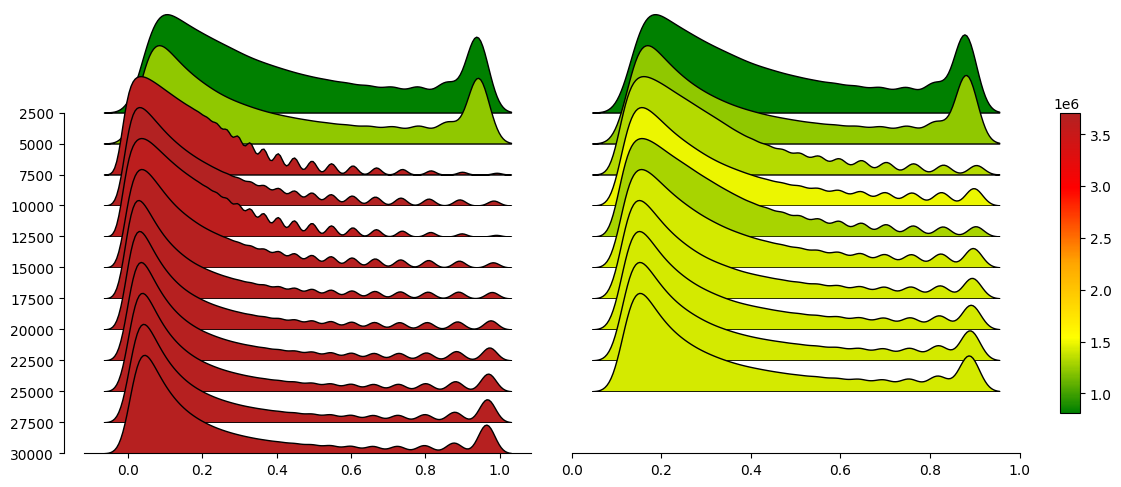

In [10]:
fig,axs = plot_histograms([event_acc.Histograms("scene/opacity_histogram") for event_acc in event_accs],scaling=10)
fig.set_size_inches(len(event_accs)*5,5)

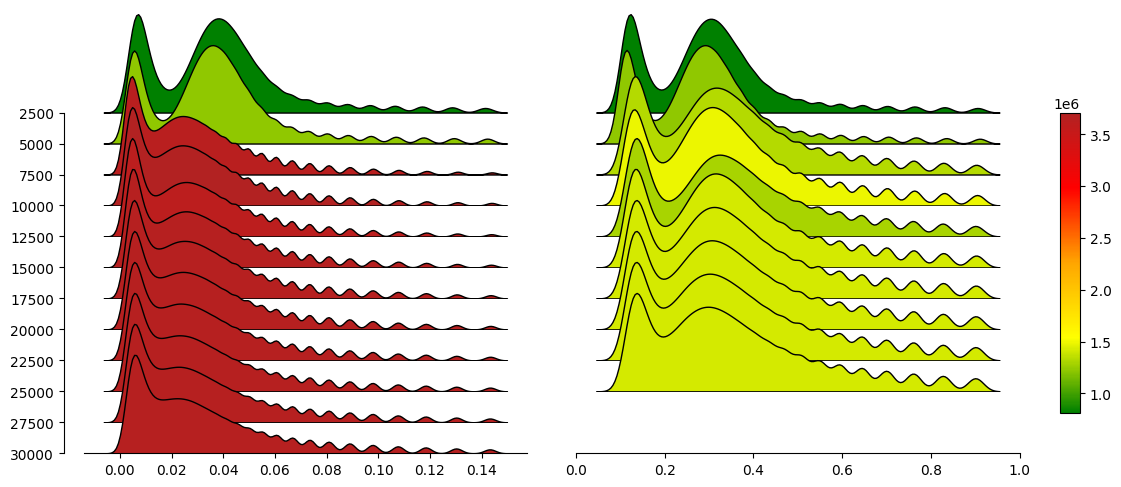

In [8]:
fig,axs = plot_histograms([event_acc.Histograms("scene/size_histogram") for event_acc in event_accs],scaling=10,upper_cutoff=0.15)
fig.set_size_inches(len(event_accs)*5,5)

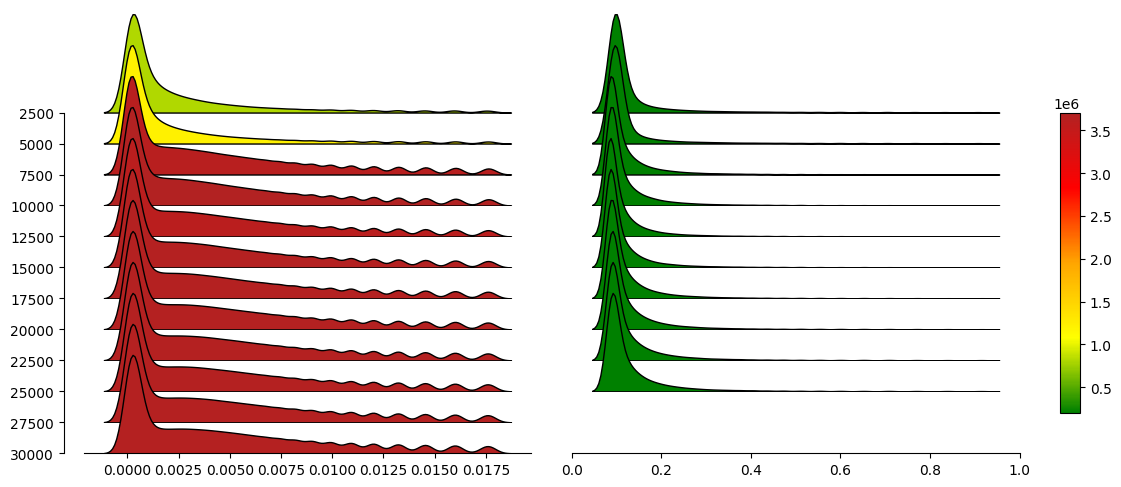

In [9]:
fig,axs = plot_histograms([event_acc.Histograms("scene/est_min_cdist_histogram") for event_acc in event_accs],scaling=10,upper_cutoff=0.02)
fig.set_size_inches(len(event_accs)*5,5)